# シミュレーションの作成
評価を行えるように。。

- 注文失敗の原因をカバー
  - 単純に注文が成立しなかった時など
- 注文成立までの時間を設定できるように
-  注文のスパンの条件

In [2]:
from init import config

config 読み込み -> config/config.ini
config 読み込み -> ../config/config.ini


In [3]:
import db
import pandas as pd
from plotter.plot import plt, set_figure

class Simulator(object):
    """bitcoinのシミュレートを行うためのもの"""
    def __init__(self, start=None, end=None, sec_by=None):
        # データの取得
        self.ticker = db.df.read_ticker(start=start, end=end, sec_by=sec_by)
        print("data {} - {}".format(self.ticker.index.min(), self.ticker.index.max()))
        self.action_space = ["buy", "sell", "stay"]
    
    def total_balance_yen(self, ltp, bitcoin, yen):
        return ltp*bitcoin + yen
    
    def simulate(self, func, start_yen):
        # funcは、ロジックを内包した関数
        #            引数はtimeとDataFrame（最新の1行）, 返却は(買い buy、売り sell、何もしない stay), (量)の２つ
        # isFXは信用か現物か。Trueで売りで入ることができる。
        #         ltp = self.ticker[["ltp"]]
        #         start = ltp.index.min().replace(hour=0, minute=0, second=0, microsecond=0)
        #         end = ltp.index.max()
        #         date_range = pd.date_range(start=start, end=end, freq='min')
        #         print("simulate {} - {}".format(date_range.min(), date_range.max()))
        
        # ログ用
        log = pd.DataFrame()
        def log_action(time, action, amount, bc, yen, total):
            nonlocal log
            #print("{time} {action} {amount}, bitcoin:{bc}, yen:{yen} total:{total}".format(time=time, action=action, amount=amount, bc=bc, yen=yen, total=total))
            info = pd.DataFrame({"action":[action], "amount":[amount], "bitcoin":[bc], "yen":[yen], "total":[total]}, index=[time])
            log = log.append(info)
            
        balance_bitcoin = 0           # bitcoinの持っている量
        balance_yen = start_yen # 日本円の残高
        for time, row in self.ticker.iterrows():
            # 一行ずつデータを与えていく。
            action, amount = func(time, row)
            # 何もしない
            if action == "stay":
                pass
            # 買い    
            elif action == "buy":
                if balance_yen > row.ltp*amount:
                    balance_bitcoin +=  amount
                    balance_yen -= row.ltp*amount
                else:
                    # print("注文失敗 日本円残高:{} < 買い注文:{}".format(balance_yen, row.ltp*amount))
                    action = "buy failed"
            # 売り
            elif action == "sell":
                if balance_bitcoin > amount:
                    balance_bitcoin -=  amount
                    balance_yen += row.ltp*amount
                else:
                    # print("注文失敗 　bitcoin残高:{} < 売り注文:{}".format(balance_bitcoin, amount))
                    action = "sell failed"
            log_action(time, action, amount, balance_bitcoin, balance_yen, self.total_balance_yen(row.ltp, balance_bitcoin, balance_yen))
        
        set_figure((16,5))
        plt.plot(self.ticker[["ltp"]], label="ltp")
        plt.show()
        plt.plot(log[["total"]], label="total_balance")
        plt.show()
        
        return log

In [4]:
sim = Simulator(sec_by=60 * 60 * 3)

2018-01-03 19:05:45,336 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2018-01-03 19:05:45,337 INFO sqlalchemy.engine.base.Engine ()
2018-01-03 19:05:45,351 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2018-01-03 19:05:45,353 INFO sqlalchemy.engine.base.Engine ()
2018-01-03 19:05:45,364 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8' and `Collation` = 'utf8_bin'
2018-01-03 19:05:45,370 INFO sqlalchemy.engine.base.Engine ()
2018-01-03 19:05:45,375 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2018-01-03 19:05:45,377 INFO sqlalchemy.engine.base.Engine ()
2018-01-03 19:05:45,382 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2018-01-03 19:05:45,384 INFO sqlalchemy.engine.base.Engine ()
2018-01-03 19:05:45,390 INFO sqlalchemy.engine.base.Engine SELECT CAST('test collated returns' AS CHAR CHARACTER SET utf8) COLLATE utf8_bin AS anon_1
2018-01-03 19

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/SQLAlchemy-1.1.9-py3.6-macosx-10.6-intel.egg/sqlalchemy/dialects/mysql/base.py:1546: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  cursor.execute('SELECT @@tx_isolation')


data 2018-01-03 16:05:46.167000+09:00 - 2018-01-03 19:05:43.270000+09:00


In [5]:
import random
def f(time, row):
    return "buy", 0.001
#     return random.choice(["buy", "sell", "stay"]), 0.001

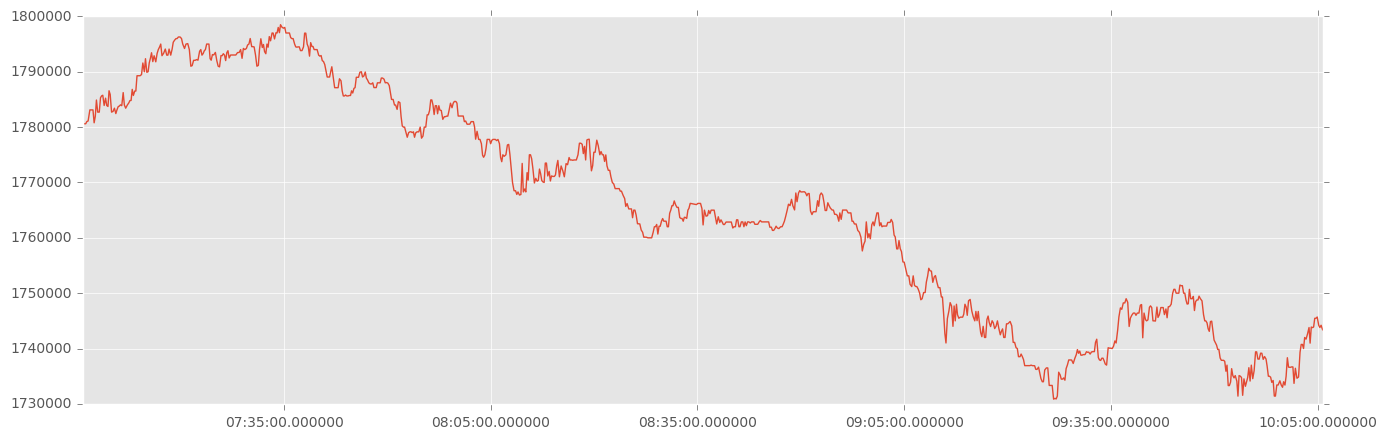

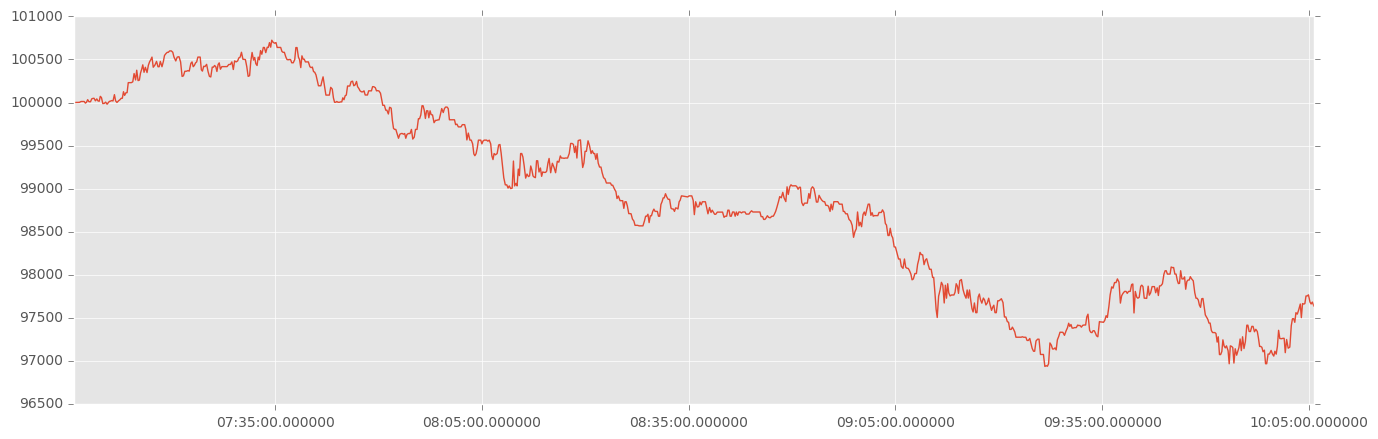

,action,amount,bitcoin,total,yen
2018-01-03 16:05:46.167000+09:00,buy,0.001,0.001,100000.000,98219.400
2018-01-03 16:05:59.703000+09:00,buy,0.001,0.002,100000.000,96438.800
2018-01-03 16:06:13.097000+09:00,buy,0.001,0.003,99999.998,94658.201
2018-01-03 16:06:23.023000+09:00,buy,0.001,0.004,100001.204,92877.200
2018-01-03 16:06:34.107000+09:00,buy,0.001,0.005,100001.628,91096.093
2018-01-03 16:06:49.393000+09:00,buy,0.001,0.006,100011.623,89312.987
2018-01-03 16:07:01.850000+09:00,buy,0.001,0.007,100011.623,87529.881
2018-01-03 16:07:16.333000+09:00,buy,0.001,0.008,100011.623,85746.775
2018-01-03 16:07:26.480000+09:00,buy,0.001,0.009,99992.999,83965.997
2018-01-03 16:07:36.537000+09:00,buy,0.001,0.010,100003.403,82184.063


In [6]:
a = sim.simulate(start_yen=100000, func=f)
a